---
---

# IMPORTS

In [1]:
INTERACTIVE = False
FIGWIDTH    = 12


# CHOOSE INTERACTIVE ON/OFF
if INTERACTIVE:
    %matplotlib widget
else:
    %matplotlib inline
#----------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
from matplotlib.legend_handler import HandlerTuple
import pandas as pd
from scipy.interpolate import interp1d
import glob
import sys
sys.path.append('../')

import pynumdiff
import fillingpatterns as fp

# Make sure this import is after pandas
import Backend.ABPPandas

import Backend.Constants as cst
import Backend.NXCALS as nx


# Matplotlib config
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"


# Creating NXCALS variable containers
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]

buckets   = np.arange(3564)


# Locating data
DATA_PATH = '/eos/project/l/lhc-lumimod/LuminosityFollowUp/2022_test_v0.2.2/'
SAVEPATH  = '../Results_Lumi_V2/wires_on'

def importData(_fill,columns):
    # Importing fill data
    df = pd.read_parquet(DATA_PATH+f'HX:FILLN={FILL}',columns=columns)
    df = df.sort_index()
    df.index.name = 'unix'
    df.insert(0,'Timestamp',df.index)
    df.insert(1,'Time',1e-9*(df.index - df.index[0]))
    df['Timestamp'] = df['Timestamp'].apply(lambda t: pd.Timestamp(t).tz_localize('UTC'))
    return df

def wireROI(df):
    wire_start = df[df[wires['B1'][0]['I']]>10]['Timestamp'].min()
    wire_stop  = df[(df[wires['B1'][0]['I']]>295)&(df['Timestamp']>wire_start)]['Timestamp'].min()
    wire_start,wire_stop = wire_start-pd.Timedelta(minutes=3),wire_stop+pd.Timedelta(minutes=3)
    return wire_start,wire_stop


def getFillingPatt(df):

    filled_buckets = {}
    patterns       = {}
    bunch_I        = {}
    for beam in beams:
        
        filled_ts = np.min(df[df[beam['Intensity']]== np.max(df[beam['Intensity']])].index)

        sub = df.dropna(subset=[beam['bb_Intensity']])
        _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
        
        
        bunch_I[beam.name]        =df.loc[_ts,beam['bb_Intensity']]
        filled_buckets[beam.name] = np.arange(len(buckets))[bunch_I[beam.name]!=0]
        patterns[beam.name]       = (bunch_I[beam.name]!=0)


    # Figuring out filling patterns
    patt = fp.FillingPattern(patterns['B1'], patterns['B2'])
    patt.compute_beam_beam_schedule(n_lr_per_side=21)

    for bb_patt in [patt.b1,patt.b2]:
        train_num     = np.repeat(np.arange(len(bb_patt.train_lengths)),bb_patt.train_lengths)
        train_lengths = np.repeat(bb_patt.train_lengths,bb_patt.train_lengths)
        bb_patt.bb_schedule.insert(0,'Train',train_num)
        bb_patt.bb_schedule.insert(1,'Train Lengths',train_lengths)
        bb_patt.bb_schedule.insert(2,'Tag',None)


        targetTrain = bb_patt.bb_schedule['Train Lengths'].max()

        grouped = bb_patt.bb_schedule.groupby('Train')
        for train in list(grouped.groups.keys()):
            if grouped.get_group(train)['Train Lengths'].max() == targetTrain:
                _first  = grouped.get_group(train).index[0]
                _middle = grouped.get_group(train).index[targetTrain//2]

                bb_patt.bb_schedule.loc[_first,'Tag']  = 'first'
                bb_patt.bb_schedule.loc[_middle,'Tag'] = 'middle'

    return patt


2022-09-22 23:03:22,742 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



# Import single fill

In [12]:

from dataclasses import dataclass


FILL = 8128

def import_all_info():
    # Importing some data for timescales
    #-----------------------------------
    var_needed  = ['HX:BMODE']
    var_needed += [wire.I for wire in wires['B1']+wires['B2']]
    var_needed += [beam['Intensity'] for beam in beams] + [beam['bb_Intensity'] for beam in beams]+ [beam['bb_Intensity_B'] for beam in beams]
    var_needed += [beam['bb_Emittance_H'] for beam in beams] + [beam['bb_Emittance_V'] for beam in beams]
    var_needed += [beams[0]['Luminosity']['ATLAS']]

    database             = importData(FILL,columns=var_needed)
    wire_start,wire_stop = wireROI(database)
    start_ts             = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
    stop_ts              = wire_start+pd.Timedelta(hours=2)
    if FILL == 8128:
        start_ts   = database[(database[beams[0]['Luminosity']['ATLAS']]>2500)&(database['Timestamp']>(stop_ts-pd.Timedelta(hours=10)))]['Timestamp'].min()
    patt                 = getFillingPatt(database) 
    #-----------------------------------

    # Loading effective cross section df
    #-----------------------------------
    xsection_df = {}
    xsection_smooth_df = {}
    for beam in beams:
        xsection_df[beam.name]        = pd.read_pickle(f"{SAVEPATH}/pickles/xsection_F{FILL}_{beam.name}.pkl")
        xsection_smooth_df[beam.name] = pd.read_pickle(f"{SAVEPATH}/pickles/xsection_smooth_F{FILL}_{beam.name}.pkl")
    #-----------------------------------
    return database,wire_start,wire_stop,start_ts,stop_ts,patt,xsection_df,xsection_smooth_df
database,wire_start,wire_stop,start_ts,stop_ts,patt,xsection_df,xsection_smooth_df = import_all_info()


Computing collision schedules...
Done Beam 1
Done Beam 2


# Test emittance

# Getting bb_parameters

In [7]:


def make_bb_parameters(df,_times):

    STABLE_start = df[df['HX:BMODE'] == 'STABLE']['Time'].iloc[0]

    # Computing avg (every 60 seconds)
    binWind = 60
    bins    = np.arange(_times[0]-binWind/2,_times[-1]+binWind/2+binWind/8,binWind)


    new_dict = {}
    for beam in beams:

        # INTENSITY
        observable = beam['Intensity']
        times,ref  = df.bin(observable,bins=bins)[['Time',observable]].T.to_numpy()
        STABLE_idx = np.argmin(np.abs(times-STABLE_start))

        observable = beam['bb_Intensity']
        total_A    = df.bin(observable,bins=bins)[observable]
        calib_A   = np.mean((ref/total_A.apply(lambda line:np.sum(line)))[STABLE_idx:STABLE_idx+int(10*(60/binWind))])

        new_dict[f'bb_Intensity_A_{beam.name}'] = total_A*calib_A

        observable = beam['bb_Intensity_B']
        total_B    = df.bin(observable,bins=bins)[observable]

        # B1 BCTFR-B needs rolling of 1 bucket (let's make it general):
        #-------------------------------------        
        rolling = buckets[(total_A.loc[STABLE_idx]!=0)&(buckets<3562)][-1]-buckets[(total_B.loc[STABLE_idx]!=0)&(buckets<3562)][-1]
        if rolling != 0 :
            total_B = total_B.apply(lambda line: np.roll(line,rolling))
            print(f'MISALIGNED {beam.name}, ROLLING BY {rolling}')
        #-------------------------------------
       
        calib_B   = np.mean((ref/total_B.apply(lambda line:np.sum(line)))[STABLE_idx:STABLE_idx+int(10*(60/binWind))])
        new_dict[f'bb_Intensity_B_{beam.name}']   = total_B*calib_B
        new_dict[f'bb_Intensity_avg_{beam.name}'] = (total_A*calib_A + total_B*calib_B)/2

        # Emittance:
        for plane in ['H','V']:
            observable = beam[f'bb_Emittance_{plane}']
            times_emitt,emitt = df.set_index('Time')[observable].dropna().to_2D()

            # Aligning times with interpolation
            #---------------------------------
            emitt = interp1d(times_emitt,emitt,axis=0,bounds_error=False,fill_value=np.nan)(times)
            emitt = pd.Series(list(emitt))

            # Test alignement?
            #-------------------------------------        
            #emitt_idx = emitt.dropna().index[np.argmin(np.abs(emitt.dropna().index - STABLE_idx))]
            rolling = buckets[(total_A.loc[STABLE_idx]!=0)&(buckets<3562)][-1]-buckets[(emitt.loc[STABLE_idx]!=0)&(buckets<3562)][-1]
            if rolling != 0 :
                emitt = emitt.apply(lambda line: np.roll(line,rolling))
                print(f'MISALIGNED EMITTANCE {beam.name}, ROLLING BY {rolling}')
            #-------------------------------------

            new_dict[f'bb_Emittance_{plane}_{beam.name}'] = emitt




    return pd.concat([  df.bin(beams[0]['Intensity'],bins=bins)[['unix','Timestamp','Time']],
                        pd.DataFrame(new_dict)],axis=1).set_index('unix')


assert(np.all(xsection_df['B1']['Time'] ==xsection_df['B2']['Time']))
bb_parameters = make_bb_parameters(database,_times=np.array(xsection_df['B1']['Time']))

MISALIGNED B1, ROLLING BY 1


# ULTIMATE PLOT

0 8120
Computing collision schedules...
Done Beam 1
Done Beam 2
MISALIGNED B1, ROLLING BY 1
1 8124
Computing collision schedules...
Done Beam 1
Done Beam 2
MISALIGNED B1, ROLLING BY 1
2 8128
Computing collision schedules...
Done Beam 1
Done Beam 2
MISALIGNED B1, ROLLING BY 1
3 8143
Computing collision schedules...
Done Beam 1
Done Beam 2
MISALIGNED B1, ROLLING BY 1


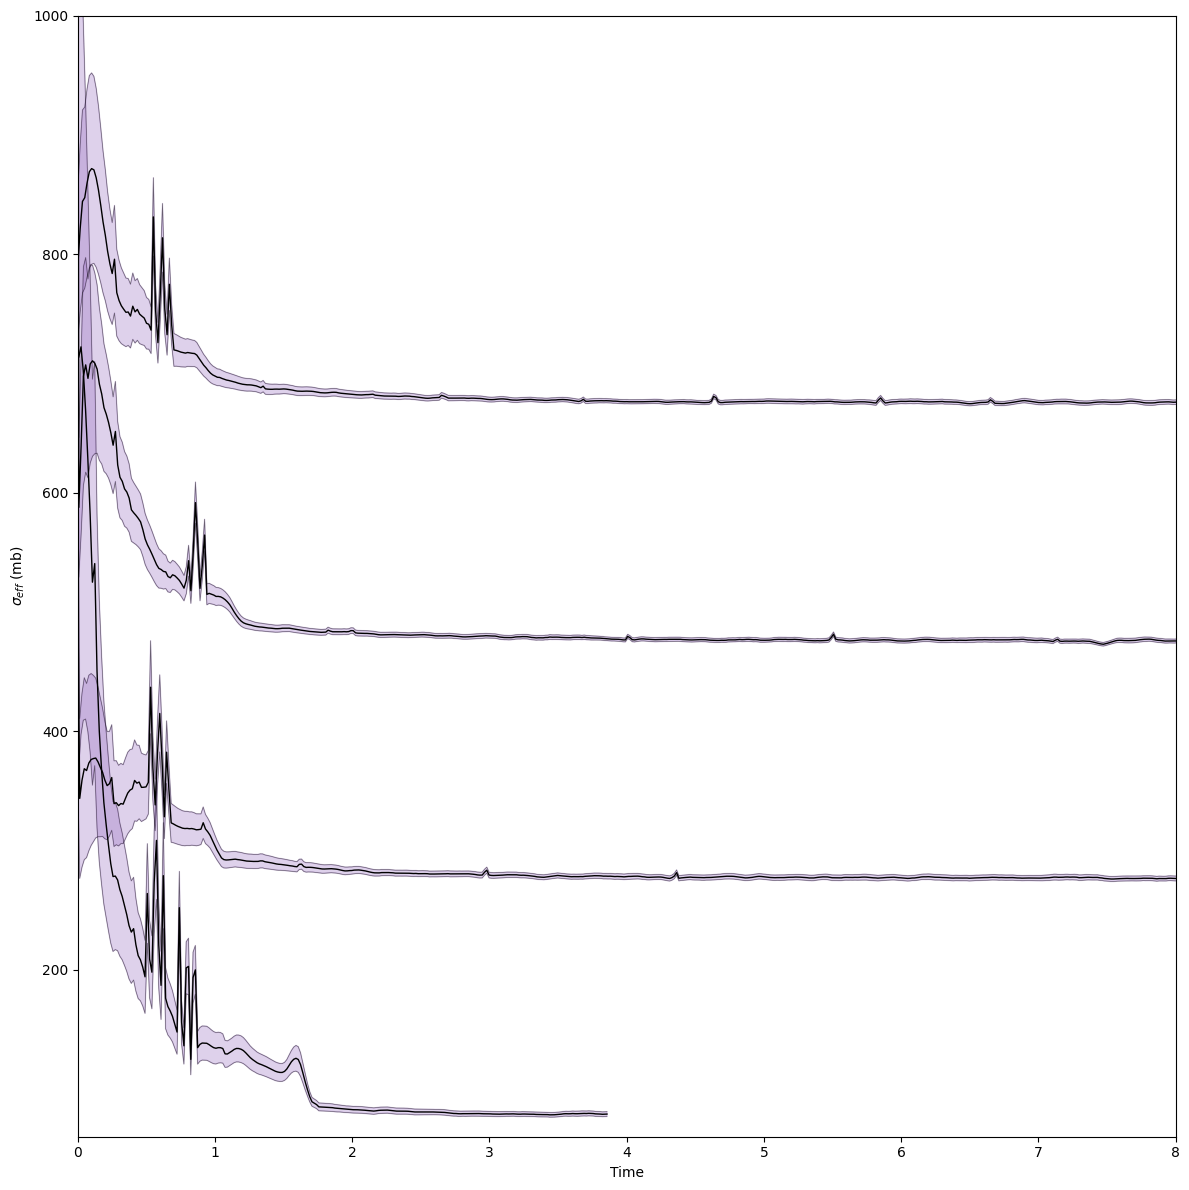

In [15]:





plt.close('all')

for idx,FILL in enumerate([8120,8124,8128,8143]):
    print(idx,FILL)
    # IMPORTING
    database,wire_start,wire_stop,start_ts,stop_ts,patt,xsection_df,xsection_smooth_df = import_all_info()
    bb_parameters = make_bb_parameters(database,_times=np.array(xsection_df['B1']['Time']))

    for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):
        if beam.name == 'B1':
            continue
    

        plt.figure(beam.name,figsize=(12,12))
        
        middles =  bb_df.groupby('Tag').get_group('middle').index
        
        tagged  = list(middles)
        tagged += list(middles-1)
        tagged += list(middles+1)


        # Computing avg
        avg_ts              = xsection_smooth_df[beam.name]['Time']
        avg_xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:np.mean(line[tagged]))

        # Computing std
        std_ts              = xsection_smooth_df[beam.name]['Time']
        std_xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:np.std(line[tagged]))

        t0 = database.at_ts(start_ts ,'Time',method='nearest')

        y0 = 200*idx + (avg_xsection_smooth)/1e-3
        y1 = 200*idx + (avg_xsection_smooth-std_xsection_smooth)/1e-3
        y2 = 200*idx + (avg_xsection_smooth+std_xsection_smooth)/1e-3
        x  = (std_ts.loc[y1.dropna().index] - t0)/3600

        color = 'C4'
        plt.fill_between(np.array(x),np.array(y1.dropna()),np.array(y2.dropna()),color=color,alpha=0.3)
        plt.plot((avg_ts-t0)/3600,y0,color='k',ls = '-',lw=1,alpha=1)
        plt.plot((std_ts-t0)/3600,y1,color='k',ls = '-',lw=0.5,alpha=0.5)
        plt.plot((std_ts-t0)/3600,y2,color='k',ls = '-',lw=0.5,alpha=0.5)



        plt.ylim([60,1000])
        plt.xlim([0,8])
        plt.ylabel(r'$\sigma_{eff}$ (mb)')
        plt.xlabel(r'Time')



        #plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')
        plt.tight_layout()
        
        #plt.savefig(f'../Results_Lumi_V2/Uppsala/final_xsection_F{FILL}_{beam.name}.png',dpi=300)



0 8102
Computing collision schedules...
Done Beam 1
Done Beam 2
MISALIGNED B1, ROLLING BY 1
1 8120
Computing collision schedules...
Done Beam 1
Done Beam 2
MISALIGNED B1, ROLLING BY 1
2 8124
Computing collision schedules...
Done Beam 1
Done Beam 2
MISALIGNED B1, ROLLING BY 1
3 8128
Computing collision schedules...
Done Beam 1
Done Beam 2
MISALIGNED B1, ROLLING BY 1
4 8143
Computing collision schedules...
Done Beam 1
Done Beam 2
MISALIGNED B1, ROLLING BY 1


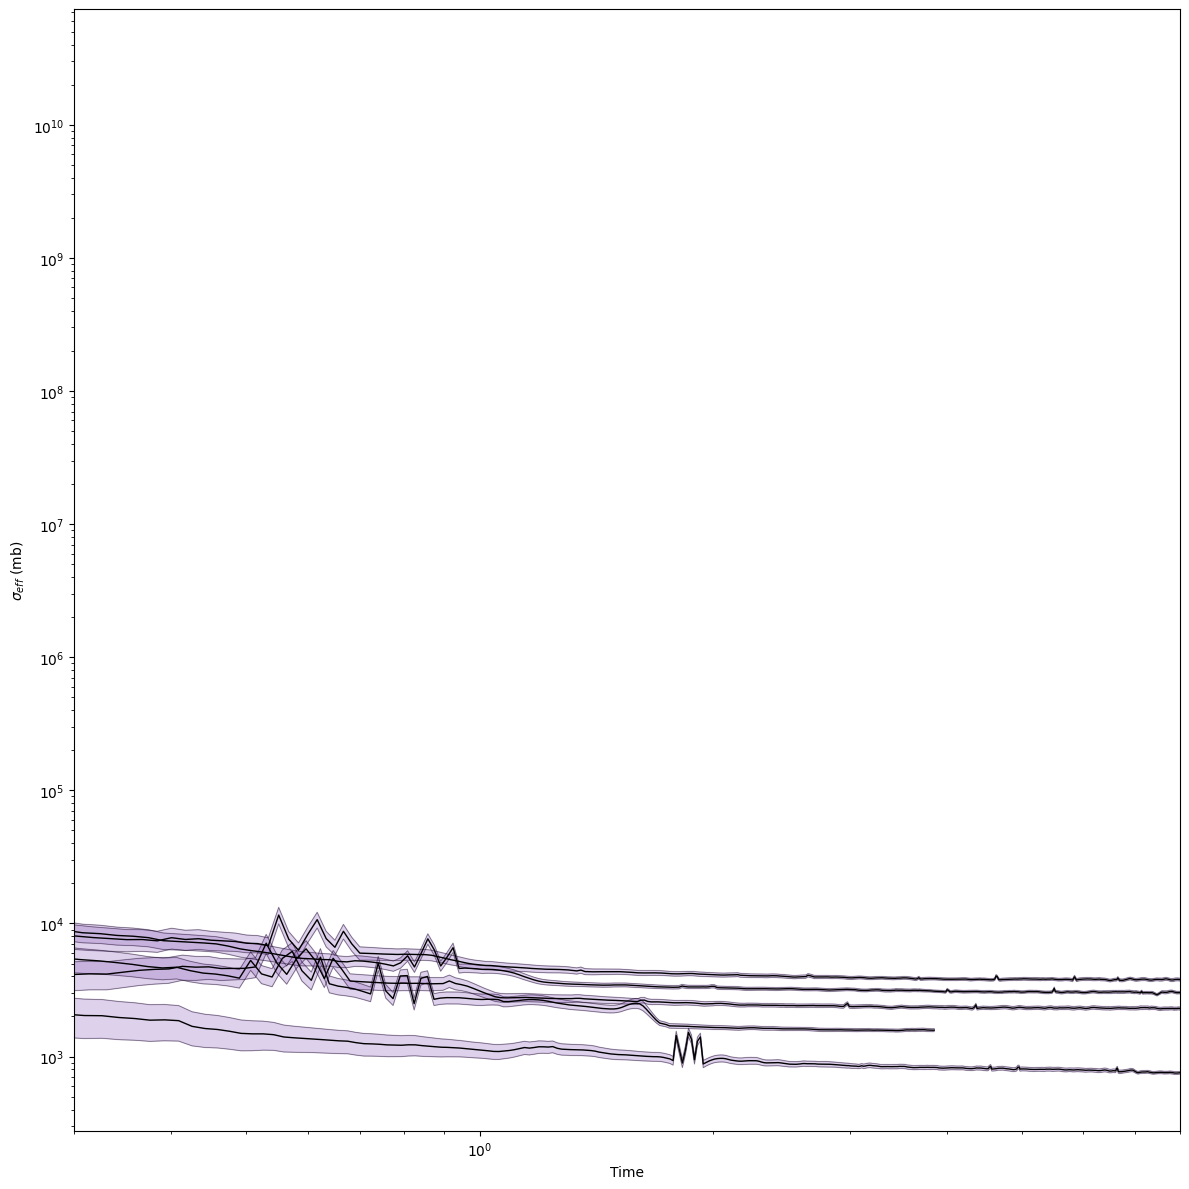

In [18]:





plt.close('all')

for idx,FILL in enumerate([8102,8120,8124,8128,8143]):
    print(idx,FILL)
    # IMPORTING
    database,wire_start,wire_stop,start_ts,stop_ts,patt,xsection_df,xsection_smooth_df = import_all_info()
    bb_parameters = make_bb_parameters(database,_times=np.array(xsection_df['B1']['Time']))

    for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):
        if beam.name == 'B1':
            continue
    

        plt.figure(beam.name,figsize=(12,12))
        
        middles =  bb_df.groupby('Tag').get_group('middle').index
        
        tagged  = list(middles)
        tagged += list(middles-1)
        tagged += list(middles+1)


        # Computing avg
        avg_ts              = xsection_smooth_df[beam.name]['Time']
        avg_xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:np.mean(line[tagged]))

        # Computing std
        std_ts              = xsection_smooth_df[beam.name]['Time']
        std_xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:np.std(line[tagged]))

        t0 = database.at_ts(start_ts ,'Time',method='nearest')

        y0 = 10*(idx+1)*(avg_xsection_smooth)/1e-3
        y1 = 10*(idx+1)*(avg_xsection_smooth-std_xsection_smooth)/1e-3
        y2 = 10*(idx+1)*(avg_xsection_smooth+std_xsection_smooth)/1e-3
        x  = (std_ts.loc[y1.dropna().index] - t0)/3600

        color = 'C4'
        plt.fill_between(np.array(x),np.array(y1.dropna()),np.array(y2.dropna()),color=color,alpha=0.3)
        plt.plot((avg_ts-t0)/3600,y0,color='k',ls = '-',lw=1,alpha=1)
        plt.plot((std_ts-t0)/3600,y1,color='k',ls = '-',lw=0.5,alpha=0.5)
        plt.plot((std_ts-t0)/3600,y2,color='k',ls = '-',lw=0.5,alpha=0.5)



        plt.ylim([6e2,2e4])
        plt.xlim([0.3,8])
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel(r'$\sigma_{eff}$ (mb)')
        plt.xlabel(r'Time')



        #plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')
        plt.tight_layout()
        
        #plt.savefig(f'../Results_Lumi_V2/Uppsala/final_xsection_F{FILL}_{beam.name}.png',dpi=300)

